#INTRODUCCION

El dataset elegido contiene más de mil críticas de películas y series españolas, extraídas del sitio web www.filmaffinity.com. Ofrece una oportunidad para aplicar y experimentar técnicas de procesamiento de texto en nuestro idioma, promoviendo el desarrollo de proyectos, análisis y modelos específicos para el español.

https://www.kaggle.com/datasets/andrsmosquera/crticas-pelculas-filmaffinity-en-espaol-netflix

El dataset esta formado por:

film_name: Título de la película.

gender: Genero de la película (comedia, terror, acción, etc.)

film_avg_rate: Nota media de la película (votos de todos los usuarios)

review_rate: Nota que el usuario que hace la crítica pone a la película.

review_title: Título de la crítica.

review_text: Crítica de la película.

##TOKENIZACION, STOPWORDS Y LEMATIZACION

In [1]:
# Bloque 1: Carga y preprocesamiento con spaCy (tokenización, stopwords, lematización)

import pandas as pd
import requests
import io
import spacy

# Descarga de archivo y encoding
url = "https://raw.githubusercontent.com/Julieta398/Data-Science-III/main/film_reviews_result2.csv"
response = requests.get(url)
raw_text = response.text
clean_text = raw_text.encode('utf-8', errors='ignore').decode('utf-8')
df = pd.read_csv(io.StringIO(clean_text), on_bad_lines='skip')

# Renombrar columna y limpiar filas sin texto
df.rename(columns={'review_text;;;;;;;;;;;;;;;;;': 'texto'}, inplace=True)
df = df.dropna(subset=['texto'])

print("=== Texto original (primeras 3 filas) ===")
print(df['texto'].head(3))

# Instalar spaCy y modelo español
!pip install -q spacy
!python -m spacy download es_core_news_sm

# Cargar modelo spaCy español
nlp = spacy.load("es_core_news_sm")

# Preprocesar y mostrar pasos
def preprocesar_con_muestras(texto):
    print("\n--- Procesando texto ---")
    print(texto)

    texto_lower = texto.lower()
    print("\n1) Texto en minúsculas:")
    print(texto_lower)

    doc = nlp(texto_lower)

    tokens = [token.text for token in doc]
    print("\n2) Tokenización:")
    print(tokens)

    tokens_sin_stop = [token.text for token in doc if not token.is_stop and not token.is_punct]
    print("\n3) Remoción de stopwords y puntuación:")
    print(tokens_sin_stop)

    lemas = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    print("\n4) Lematización:")
    print(lemas)

    return lemas

# Aplicar solo a 2 filas (para no saturar)
df_sample = df.head(2).copy()
df_sample['tokens'] = df_sample['texto'].apply(preprocesar_con_muestras)

print("\n=== Resultado final con tokens lematizados ===")
print(df_sample[['texto', 'tokens']])


=== Texto original (primeras 3 filas) ===
0    Como fan de las series españolas y de Najwa. e...
3    Nadie te obliga a ver nada que no quieras ver ...
4    Está serie da vergüenza ajena. Una serie donde...
Name: texto, dtype: object
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 91.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.

--- Procesando texto ---
Como fan de las series españolas y de Najwa. esto duele. la serie es muy mala.Manu Ríos da para lo que da. enseñar cacho. Najwa hace de mala. papel repetido que no aporta ninguna capa nueva.Telenovela de mediodía con un guión mediocre y diálogos planos.En aspectos técnicos como fotografía. sonido. también deja que desear

Reducción de ruido y generalización del texto: por la lematización y la remoción de stopwords, se logró reducir el texto a conceptos escenciales. Terminos como "obliga", "obligar", "mala", "malo", se unificaron a su forma base y esto permite mejorar la calidad del análisis posterior (ej. análisis de sentimiento o clasificación).

Preservación de la opinión crítica: pese al filtro, los tokens dinales siguen mostrando con claridad el tono negativo de las críticas. "Mediocre", "vergeunza", "crítica", "falta", "culpa", "malo", muestran sentimientos desfavorables lo que confirmaría que el preprocesamiento no elimina lo relevante de las críticas.

Desbalance temático y tono en las reseñas: se observan bastantes palabras negativas y adjetivos con carga fuerte ("mediocre", "ofensiva", "doler", "verguenza") lo que indicaría que muchas reseñas puedan tener una polaridad negativa y esto podría influir en modelos de clasificación.

##ANALISIS DE SENTIMIENTO Y PALABRAS CALVE

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.4 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Ejemplos de sentimiento:
                                               texto  sentimiento
0  Como fan de las series espaolas y de Najwa. es...       0.0258
3  Nadie te obliga a ver nada que no quieras ver ...      -0.8900
4  Est serie da vergenza ajena. Una serie donde a...      -0.7845
5  Puntuacin:  de 5Elitizando un hospital.Por mga...      -0.7906
6  *Una serie que lucha por capturar la realidad ...      -0.9922

Top 10 palabras con mayor TF-IDF promedio:
ms: 0.0644
serie: 0.0620
pelcula: 0.0571
si: 0.0396
historia: 0.0389
bien: 0.0370
est: 0.0329
ser: 0.0324
personajes: 0.0324
ver: 0.0301


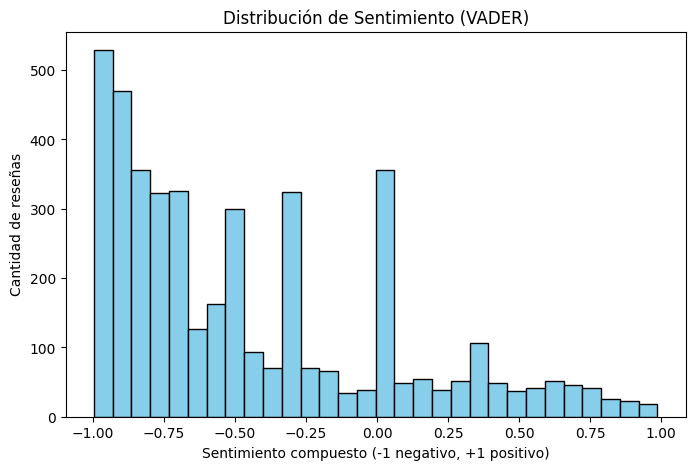

In [2]:
# Bloque 2: Análisis de sentimiento (VADER) y TF-IDF vectorizer

# Librerías necesarias
!pip install -q vaderSentiment
!pip install -q scikit-learn
import nltk
nltk.download('stopwords')

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

# Limpieza de texto para evitar caracteres raros
df['texto'] = df['texto'].apply(lambda x: x.encode('latin1', errors='ignore').decode('utf-8', errors='ignore'))

# Inicializar analizador VADER
analyzer = SentimentIntensityAnalyzer()

# Función para obtener sentimiento
def obtener_sentimiento_vader(texto):
    vs = analyzer.polarity_scores(str(texto))
    return vs['compound']

df['sentimiento'] = df['texto'].apply(obtener_sentimiento_vader)

print("Ejemplos de sentimiento:")
print(df[['texto', 'sentimiento']].head())

# TF-IDF con stopwords en español (de nltk)
spanish_stopwords = stopwords.words('spanish')
vectorizer = TfidfVectorizer(max_features=1000, stop_words=spanish_stopwords)
tfidf_matrix = vectorizer.fit_transform(df['texto'])

tfidf_means = tfidf_matrix.mean(axis=0).A1
features = vectorizer.get_feature_names_out()
top_n = 10
top_n_ids = np.argsort(tfidf_means)[::-1][:top_n]

print("\nTop 10 palabras con mayor TF-IDF promedio:")
for i in top_n_ids:
    print(f"{features[i]}: {tfidf_means[i]:.4f}")

# Grafica de distribución de sentimientos
plt.figure(figsize=(8,5))
plt.hist(df['sentimiento'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribución de Sentimiento (VADER)')
plt.xlabel('Sentimiento compuesto (-1 negativo, +1 positivo)')
plt.ylabel('Cantidad de reseñas')
plt.show()


Análisis de senntimiento: varias críticas tienden a ser negativas (ejemplo una de las reseñas con -0.9922 rechazo casi absoluto). Pocas reseñas presentan valores positivos lo que puede sugerir que predominan opiniones negativas o que los ejemplos elegidos tienden a destacar lo negativo.
Esta información es útil al entrenar un modelo de clasificación de sentimiento, ya que se observa desbalance en las clases (más críticas negativas que positivas), lo cual habría que tener en cuenta.

Análisis TF-IDF (términos más representativos): las palabras con mayor peso promedio son: "más", "serie", "película", "historia", "bien", "ver", entre otras. Esto indica que el contenido de las críticas gira en torno a opiniones personales sobre las tramas, personajes y calidad general de las series/películas. Términos como "serie", "película", "historia", "personajes" sugiere que las críticas se centran en aspectos narrativos y de guion.

##TRIGRAMA

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/tmp/ipython-input-3-1125401922.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(freqs), y=list(trigramas), palette='cubehelix')


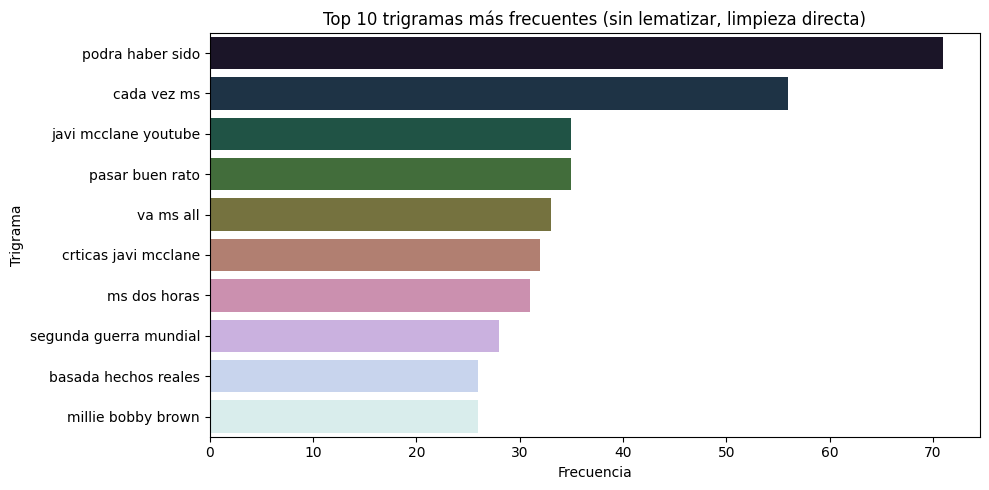

In [3]:
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import re
import seaborn as sns
import matplotlib.pyplot as plt

nltk.download('stopwords')
spanish_stopwords = set(stopwords.words('spanish'))

# 1. Eliminar URLs y caracteres especiales
def limpiar_texto_simple(texto):
    texto = texto.lower()
    texto = re.sub(r"http\S+|www\S+|https\S+", "", texto)
    texto = re.sub(r"[^a-záéíóúñü\s]", "", texto)
    return texto

df['texto_limpio'] = df['texto'].apply(limpiar_texto_simple)

# 2. Vectorizador de trigramas con stopwords personalizadas
vectorizer_trigramas = CountVectorizer(
    ngram_range=(3,3),
    stop_words=list(spanish_stopwords),
    max_features=1000
)

X_trigramas = vectorizer_trigramas.fit_transform(df['texto_limpio'])
suma_trigramas = X_trigramas.sum(axis=0).A1
trigramas = vectorizer_trigramas.get_feature_names_out()
frecuencias = list(zip(trigramas, suma_trigramas))
frecuencias_ordenadas = sorted(frecuencias, key=lambda x: x[1], reverse=True)
top_10 = frecuencias_ordenadas[:10]

# 3. Verificar si hay resultados y graficar
if len(top_10) == 0:
    print("⚠️ No se encontraron trigramas válidos.")
else:
    trigramas, freqs = zip(*top_10)

    plt.figure(figsize=(10,5))
    sns.barplot(x=list(freqs), y=list(trigramas), palette='cubehelix')
    plt.title("Top 10 trigramas más frecuentes (sin lematizar, limpieza directa)")
    plt.xlabel("Frecuencia")
    plt.ylabel("Trigrama")
    plt.tight_layout()
    plt.show()


Trigramas informativos y contextuales: “podrá haber sido”, “cada vez más” o “pasar buen rato” muestran expresiones comunes que aportan información emocional, típico de reseñas subjetivas.

Relevancia de personas o personajes: nombres propios como “javi mcclane youtube” o “millie bobby brown” sugiere que hay críticas dirigidas a actores o creadores específicos, puede ser útil si se quiere aplicar análisis de entidades o segmentar por tipo de contenido.

Temas históricos o basados en hechos reales: “segunda guerra mundial” o “basada hechos reales” indican que ciertos tópicos recurrentes dentro de las reseñas hacen referencia a géneros o contextos históricos. Esto puede ser útil para clasificar temáticamente los textos o identificar tendencias narrativas.

El hecho de que aparezcan trigramas como “va ms all” o “crticas javi mcclane” indica que aún hay ruido en los datos. Esto sugiere que una limpieza más profunda podría mejorar la calidad de los análisis posteriores.

